# GNN Decoder Experiments for 5G NR LDPC codes

This notebook reproduces the 5G NR LDPC code results in the paper [Graph Neural Networks for Channel Decoding](https://arxiv.org/pdf/2207.14742.pdf).

**Remark**: the training can take several hours. However, pre-trained weights are stored in this repository and can be directly loaded to reproduce the results.

This notebook requires [Sionna](https://nvlabs.github.io/sionna/).

In [2]:
# general imports
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# load required Sionna components
from sionna.fec.utils import load_parity_check_examples, LinearEncoder, gm2pcm
from sionna.utils.plotting import PlotBER
from sionna.fec.ldpc import LDPCBPDecoder, LDPC5GEncoder, LDPC5GDecoder

%load_ext autoreload
%autoreload 2
from gnn import * # load GNN functions
from wbp import * # load weighted BP functions

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 1 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 0


## Define Hyperparameters and Load Code

We define all parameters as dictionary to support different architectures for different codes.


In [4]:
#----- LDPC 5G -----
params={
    # --- Code Parameters ---
        "code": "5G-LDPC",
        "n": 140,
        "k": 60,
    # --- GNN Architecture ----
        "num_embed_dims": 16,
        "num_msg_dims": 16,
        "num_hidden_units": 48,
        "num_mlp_layers": 3,
        "num_iter": 10,
        "reduce_op": "sum",
        "activation": "relu",
        "clip_llr_to": 20,
        "use_attributes": False,
        "node_attribute_dims": 0,
        "msg_attribute_dims": 0,
        "return_infobits": False,
        "use_bias": True,        
    # --- Training ---- # 
        "batch_size": [128, 128, 128], # bs, iter, lr must have same dim
        "train_iter": [35000, 300000, 300000],
        "learning_rate": [5e-4, 1e-4, 1e-5],
        "ebno_db_train": [2, 8.],
        "ebno_db_eval": 2.,       
        "batch_size_eval": 1000, # batch size only used for evaluation during training
        "eval_train_steps": 1000, # evaluate model every N iters
    # --- Log ----
        "save_weights_iter": 10000, # save weights every X iters
        "run_name": "LDPC_5G_01", # name of the stored weights/logs
        "save_dir": "results/", # folder to store results
    # --- MC Simulation parameters ----
        "eval_num_iter": 10, # number of decoding iters to evaluate
        "mc_iters": 100,
        "mc_batch_size": 1000,
        "num_target_block_errors": 500,
        "ebno_db_min": 0.,
        "ebno_db_max": 4.5,
        "ebno_db_stepsize": 0.5,
        "eval_ns": [140, 280, 420, 280, 280, 280], # evaluate different lengths
        "eval_ks": [60, 120, 180, 120, 90, 150],    
        "sim_esno": False, # simulate results in EsN0
}

## Generate the 5G Decoding Graph

The 5G NR LDPC code is closely connected to rate-matching and, thus, a few graph pre-processing steps are required for our decoder.
We perform the following steps:
- Train including the first 2*Z punctured information bits (i.e., no puncturing for the training)
- Prune the parity-check matrix as much as possible and remove shortened positions from the graph

We would like to emphasize that the resulting trained GNN decoder is compliant with the standard code structure.

In [5]:
# all codes must provide an encoder-layer and a pcm
if params["code"]=="5G-LDPC":    
    print("Loading 5G NR LDPC code") 

    k = params["k"]
    n = params["n"]
    
    encoder_5g = LDPC5GEncoder(k, n)
    decoder_5g = LDPC5GDecoder(encoder_5g,
                               num_iter=params["eval_num_iter"],
                               return_infobits=False,
                               prune_pcm=True)
    
    pcm,_ = generate_pruned_pcm_5g(decoder_5g, n)
    
    n_no_rm = pcm.shape[1]
    k_no_rm = pcm.shape[1] - pcm.shape[0]

    # create encoder without rate-matching
    u_ref = np.eye(k)
    c_ref = encoder_5g(u_ref).numpy()
    gm = np.concatenate([u_ref[:,:2*encoder_5g._z], c_ref], axis=1)
    encoder_no_rm = LinearEncoder(gm, is_pcm=False)

else:
    raise ValueError("Unknown code type")

Loading 5G NR LDPC code
using bg:  bg2
# information bits: 60
CW length after rate-matching: 140
CW length without rm (incl. first 2*Z info bits): 160
# punctured bits: 320
# pruned nodes: 320
# parity bits 100
# shortened bits 40
pruned pcm dimension: (100, 160)


## Simulate Baseline BER Performance

In [6]:
ber_plot = PlotBER(f"GNN-based Decoding - {params['code']}, (k,n)=({k},{n})")
ebno_dbs = np.arange(params["ebno_db_min"],
                     params["ebno_db_max"]+1,
                     params["ebno_db_stepsize"])

In [7]:
# uncoded QPSK
e2e_uncoded = E2EModel(None, None, k=100, n=100) # k and n are not relevant here
ber_plot.simulate(e2e_uncoded,
                  ebno_dbs=ebno_dbs,
                  batch_size=params["mc_batch_size"],
                  num_target_block_errors=params["num_target_block_errors"],
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=params["mc_iters"],
                  forward_keyboard_interrupt=False,
                  show_fig=False);

2023-11-13 02:01:11.065486: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14e3bf6a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-13 02:01:11.065634: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-13 02:01:11.086730: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. binary_source/random_uniform
2023-11-13 02:01:11.122184: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-13 02:01:11.168153: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mapper/assert_greater_equal/Assert/Assert
2023-11-13 02:01:11.168193: W tensorflow/compiler/tf2xla/kernels/assert_o

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 7.8280e-02 | 1.0000e+00 |        7828 |      100000 |         1000 |        1000 |         0.9 |reached target block errors
      0.5 | 6.8710e-02 | 9.9900e-01 |        6871 |      100000 |          999 |        1000 |         0.0 |reached target block errors
      1.0 | 5.5430e-02 | 9.9800e-01 |        5543 |      100000 |          998 |        1000 |         0.0 |reached target block errors
      1.5 | 4.6490e-02 | 9.9200e-01 |        4649 |      100000 |          992 |        1000 |         0.0 |reached target block errors
      2.0 | 3.7450e-02 | 9.7900e-01 |        3745 |      100000 |          979 |        1000 |         0.0 |reached target block errors
      2.5 | 3.0120e-02 | 9.5200e-01 |        3012 |      100000 |

2023-11-13 02:01:11.468667: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### GNN-based Decoding without Rate-matching

For the training, we ignore the rate-matching and train the decoder
only for the given parity-check matrix.


In [8]:
tf.random.set_seed(2) # we fix the seed to ensure stable convergence 

# init the GNN decoder
gnn_decoder = GNN_BP(pcm=pcm,
                     num_embed_dims=params["num_embed_dims"],
                     num_msg_dims=params["num_msg_dims"],
                     num_hidden_units=params["num_hidden_units"],
                     num_mlp_layers=params["num_mlp_layers"],
                     num_iter=params["num_iter"],
                     reduce_op=params["reduce_op"],
                     activation=params["activation"],
                     output_all_iter=True,
                     clip_llr_to=params["clip_llr_to"],
                     use_attributes=params["use_attributes"],
                     node_attribute_dims=params["node_attribute_dims"],
                     msg_attribute_dims=params["msg_attribute_dims"],
                     use_bias=params["use_bias"])
                     
e2e_gnn = E2EModel(encoder_no_rm, gnn_decoder, k_no_rm, n_no_rm)

In [9]:
# init model and print summary
e2e_gnn(1, 1.)
e2e_gnn.summary()

2023-11-13 02:01:14.927944: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mapper_1/assert_greater_equal/Assert/Assert
2023-11-13 02:01:14.927992: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator awgn_1/assert_greater_equal/Assert/Assert
2023-11-13 02:01:14.928002: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator awgn_1/assert_less_equal/Assert/Assert
2023-11-13 02:01:14.928011: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator awgn_1/assert_greater_equal_1/Assert/Assert


Model: "e2e_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 binary_source_1 (BinarySou  multiple                  0         
 rce)                                                            
                                                                 
 mapper_1 (Mapper)           multiple                  0         
                                                                 
 demapper_1 (Demapper)       multiple                  0         
                                                                 
 awgn_1 (AWGN)               multiple                  0         
                                                                 
 gnn_bp (GNN_BP)             multiple                  18929     
                                                                 
 linear_encoder (LinearEnco  multiple                  0         
 der)                                                  

In [17]:
# and let's train the model...
train = False # remark: training takes several hours
if train:    
    train_gnn(e2e_gnn, params)
else:
    # you can also load the precomputed weights
    load_weights(e2e_gnn, "weights/LDPC_5G_precomputed.npy")

In [18]:
# pruning function
import pandas as pd
from tensorflow.python.ops.script_ops import numpy_function
import random

# pruning percentage
K = [5]

msg_mlp = e2e_gnn._decoder.update_h_vn._msg_mlp._layers
embed_mlp = e2e_gnn._decoder.update_h_vn._embed_mlp._layers

num_msg_mlp_layers = len(msg_mlp)
num_embed_mlp_layers = len(embed_mlp)

# pruning function 구현
def pruner_mlp(mlp): # K 에 맞는 비율로 pruning을 진행한다.
    all_weights = {}

    for layer_no in range(len(mlp) -1):

        layer_weights = (pd.DataFrame(mlp[layer_no].get_weights()[0]).stack()).to_dict()

        layer_weights = {(layer_no, k[0], k[1]): v for k, v in layer_weights.items()}
        all_weights.update(layer_weights)
        
    all_weights_sorted = {k: v for k, v in sorted(all_weights.items(), key=lambda item: abs(item[1]))}

    total_no_weights = len(all_weights_sorted)

    for pruning_percent in K:
        for layer_no in range(len(mlp) -1):

            new_weights = mlp[layer_no].get_weights()
        
            prune_fraction = pruning_percent/100 # K에서 지정한 비율만큼 pruning
            number_of_weights_to_be_pruned = int(prune_fraction*total_no_weights)
            weights_to_be_pruned = {k: all_weights_sorted[k] for k in list(all_weights_sorted)[ :  number_of_weights_to_be_pruned]}
            
            for k, v in weights_to_be_pruned.items():
                if(len(new_weights[k[0]].shape)==2):
                    new_weights[k[0]][k[1], k[2]]=0 # weights_to_be_pruned에 저장된 인덱스의 가중치를 0으로 만들어 준다.
                elif (len(new_weights[k[0]].shape)==1):
                    new_weights[k[0]][k[1]]=0
                else:
                    print('fail')

            mlp[layer_no].set_weights(new_weights)

def random_pruner_mlp(mlp): # random pruning을 진행한다.
    all_weights = {}

    for layer_no in range(len(mlp) -1):
        layer_weights = (pd.DataFrame(mlp[layer_no].get_weights()[0]).stack()).to_dict()
        layer_weights = {(layer_no, k[0], k[1]): v for k, v in layer_weights.items()}
        all_weights.update(layer_weights)
    
    print(all_weights)
    all_weights_sorted = {k: v for k, v in sorted(all_weights.items(), key=lambda item: abs(item[1]))}
    
    print(all_weights_sorted)
    total_no_weights = len(all_weights_sorted)
    
    for pruning_percent in K:
        for layer_no in range(len(mlp) -1):
            new_weights = mlp[layer_no].get_weights()
            
            prune_fraction = pruning_percent / 100 # K에서 지정한 비율만큼 pruning
            number_of_weights_to_be_pruned = int(prune_fraction*total_no_weights)
            # random pruning에서 중요한 부분
            random_indices = np.random.choice(total_no_weights, size=number_of_weights_to_be_pruned, replace=False)
            random_weights_to_be_pruned = [list(layer_weights.keys())[i] for i in random_indices]

            for k, v in weights_to_be_pruned.items():
                if(len(new_weights[k[0]].shape)==2):
                    new_weights[k[0]][k[1], k[2]]=0 # weights_to_be_pruned에 저장된 인덱스의 가중치를 0으로 만들어 준다.
                elif (len(new_weights[k[0]].shape)==1):
                    new_weights[k[0]][k[1]]=0
                else:
                    print('fail')
            
            mlp[layer_no].set_weights(new_weights)  
            

## pruning 적용

random_pruner_mlp(Random하게 0으로 설정) / pruner_mlp(가중치의 절대값이 작은 것부터 지정한만큼 0으로 설정)

K=[] 의 값을 조정하면서 학습하면 된다.

In [19]:
pruner_mlp(msg_mlp)
pruner_mlp(embed_mlp)

## Evaluate Final Performance

We now evaluate the performance for different codeword lengths and different rates.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.4531e-01 | 9.2400e-01 |       20344 |      140000 |          924 |        1000 |         0.8 |reached target block errors
      0.5 | 1.1308e-01 | 7.8800e-01 |       15831 |      140000 |          788 |        1000 |         0.1 |reached target block errors
      1.0 | 7.5557e-02 | 5.8900e-01 |       10578 |      140000 |          589 |        1000 |         0.0 |reached target block errors
      1.5 | 4.7346e-02 | 4.1000e-01 |       13257 |      280000 |          820 |        2000 |         0.1 |reached target block errors
      2.0 | 2.3636e-02 | 2.1833e-01 |        9927 |      420000 |          655 |        3000 |         0.1 |reached target block errors
      2.5 | 1.0181e-02 | 1.0020e-01 |        7127 |      700000 |

      3.0 | 1.4401e-04 | 7.1714e-03 |        4234 |    29400000 |          502 |       70000 |         8.9 |reached target block errors
      3.5 | 1.0667e-05 | 7.2000e-04 |         448 |    42000000 |           72 |      100000 |        12.4 |reached max iter       
      4.0 | 1.6667e-07 | 2.0000e-05 |           7 |    42000000 |            2 |      100000 |        12.4 |reached max iter       
      4.5 | 9.5238e-08 | 1.0000e-05 |           4 |    42000000 |            1 |      100000 |        12.4 |reached max iter       
      5.0 | 0.0000e+00 | 0.0000e+00 |           0 |    42000000 |            0 |      100000 |        12.4 |reached max iter       

Simulation stopped as no error occurred @ EbNo = 5.0 dB.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.9129e-01

      0.5 | 2.3534e-01 | 1.0000e+00 |       65895 |      280000 |         1000 |        1000 |         2.0 |reached target block errors
      1.0 | 2.2743e-01 | 1.0000e+00 |       63681 |      280000 |         1000 |        1000 |         1.8 |reached target block errors
      1.5 | 2.1874e-01 | 1.0000e+00 |       61247 |      280000 |         1000 |        1000 |         2.5 |reached target block errors
      2.0 | 2.1098e-01 | 1.0000e+00 |       59074 |      280000 |         1000 |        1000 |         2.2 |reached target block errors
      2.5 | 2.0495e-01 | 1.0000e+00 |       57387 |      280000 |         1000 |        1000 |         1.9 |reached target block errors
      3.0 | 2.0064e-01 | 1.0000e+00 |       56180 |      280000 |         1000 |        1000 |         2.0 |reached target block errors
      3.5 | 1.9540e-01 | 1.0000e+00 |       54713 |      280000 |         1000 |        1000 |         1.9 |reached target block errors
      4.0 | 1.9048e-01 | 1.0000e+00 |       5333

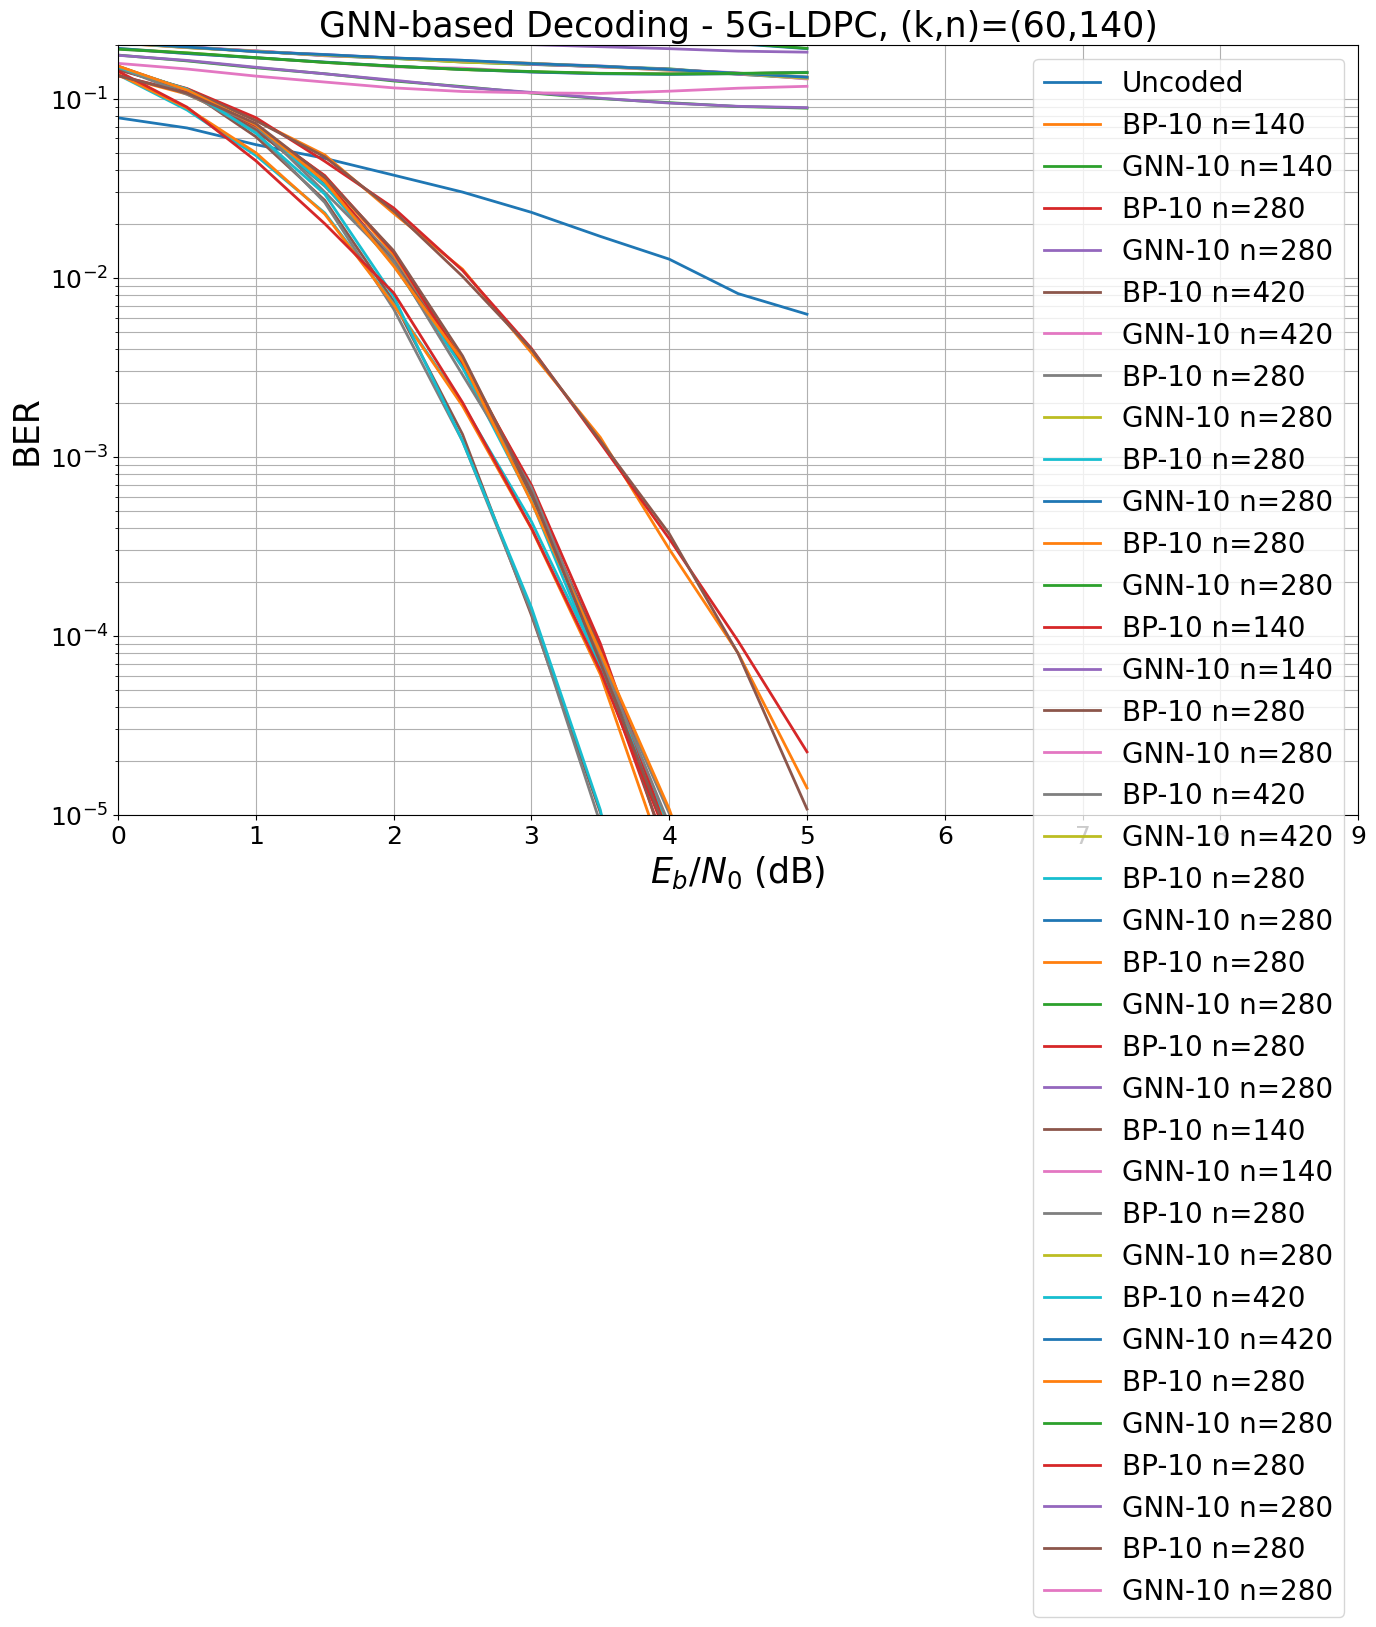

In [20]:
for idx, n_eval in enumerate(params["eval_ns"]):
    k_eval = params["eval_ks"][idx]
    
    # generate new code for each length
    encoder_5g_eval = LDPC5GEncoder(k_eval , n_eval)
    decoder_5g_eval = LDPC5GDecoder(encoder_5g_eval,
                                    num_iter=params["eval_num_iter"],
                                    return_infobits=params["return_infobits"])
    e2e_bp = E2EModel(encoder_5g_eval,
                      decoder_5g_eval,
                      k_eval,
                      n_eval,
                      return_infobits=params["return_infobits"],
                      es_no=params["sim_esno"] )

    ber_plot.simulate(e2e_bp,
                  ebno_dbs=ebno_dbs,
                  batch_size=params["mc_batch_size"],
                  num_target_block_errors=params["num_target_block_errors"],
                  legend=f"BP-{decoder_5g._num_iter.numpy()} n={n_eval}",
                  soft_estimates=True,
                  max_mc_iter=params["mc_iters"],
                  forward_keyboard_interrupt=False,
                  show_fig=False);
    # instantiate new decoder for each number of iter (otherwise no retracing)
    gnn_decoder_rm_eval = LDPC5GGNN(encoder_5g_eval,
                     num_embed_dims=params["num_embed_dims"],
                     num_msg_dims=params["num_msg_dims"],
                     num_hidden_units=params["num_hidden_units"],
                     num_mlp_layers=params["num_mlp_layers"],
                     num_iter=params["eval_num_iter"],
                     reduce_op=params["reduce_op"],
                     activation=params["activation"],
                     output_all_iter=False,
                     clip_llr_to=params["clip_llr_to"],
                     use_attributes=params["use_attributes"],
                     node_attribute_dims=params["node_attribute_dims"],
                     msg_attribute_dims=params["msg_attribute_dims"],
                     return_infobits=params["return_infobits"],
                     use_bias=params["use_bias"])    
    # generate new model   
    model = E2EModel(encoder_5g_eval,
                     gnn_decoder_rm_eval,
                     k_eval,
                     n_eval,
                     return_infobits=params["return_infobits"],
                     es_no=params["sim_esno"] )
    model(1,1.) # init model
    # copy weights from trained decoder
    model._decoder.set_weights(gnn_decoder.get_weights())

    # and run the BER simulations
    ber_plot.simulate(model,
                     ebno_dbs=ebno_dbs,
                     batch_size=params["mc_batch_size"],
                     num_target_block_errors=params["num_target_block_errors"],
                     legend=f"GNN-{model._decoder.num_iter} n={n_eval}",
                     soft_estimates=True,
                     max_mc_iter=params["mc_iters"],
                     forward_keyboard_interrupt=False,
                     show_fig=False);

ber_plot(xlim=[0, 5], ylim=[1e-5, 0.2]) # show final figure

**Remark**: This figures shows the results of Fig. 5a and Fig. 5b in the paper (Fig. 5a is plotted in the Es/N0 domain)

In [21]:
# save results for pgf plots
col_names = ["uncoded"]
for idx,n in enumerate(params["eval_ns"]):
    col_names.append("bp_k" + str(params["eval_ks"][idx]) + "_n" + str(n))
    col_names.append("gnn_k" + str(params["eval_ks"][idx]) + "_n" + str(n))
export_pgf(ber_plot, col_names)

snr, 	uncoded, 	bp_k60_n140, 	gnn_k60_n140, 	bp_k120_n280, 	gnn_k120_n280, 	bp_k180_n420, 	gnn_k180_n420, 	bp_k120_n280, 	gnn_k120_n280, 	bp_k90_n280, 	gnn_k90_n280, 	bp_k150_n280, 	gnn_k150_n280, 	
0.000,	7.828000E-02,	1.463000E-01,	2.064429E-01,	1.503750E-01,	2.052464E-01,	1.518667E-01,	2.058810E-01,	1.498786E-01,	2.047250E-01,	1.360929E-01,	2.746929E-01,	1.342107E-01,	1.754357E-01,	
0.500,	6.871000E-02,	1.136143E-01,	1.933071E-01,	1.126179E-01,	1.953393E-01,	1.119738E-01,	1.939976E-01,	1.103143E-01,	1.930750E-01,	8.656429E-02,	2.656857E-01,	1.061893E-01,	1.627929E-01,	
1.000,	5.543000E-02,	7.574286E-02,	1.846786E-01,	6.605714E-02,	1.846286E-01,	6.139286E-02,	1.842643E-01,	6.851429E-02,	1.838107E-01,	4.821071E-02,	2.620321E-01,	7.020000E-02,	1.489714E-01,	
1.500,	4.649000E-02,	4.859286E-02,	1.746571E-01,	3.554286E-02,	1.738714E-01,	2.709286E-02,	1.759214E-01,	3.252679E-02,	1.754857E-01,	2.304286E-02,	2.561107E-01,	3.702500E-02,	1.379857E-01,	
2.000,	3.745000E-02,	2.291905E-02,	1.6792